In [1]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"


opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [2]:
!apt-get update
!apt-get install -y fonts-noto


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]                                
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]                           
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]                             
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]                 
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,724 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]              
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,992 kB]               
Get:11 http

In [3]:
!pip install torch torchvision transformers opencv-python scikit-learn googletrans==4.0.0rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=085d7b7e5cb6c7bd0c8eb4454b2bd52d259445cbf59fa81b48ca8771377b3550
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hype

In [4]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle, class_weight
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import random


In [6]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [7]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label'], dtype='object')


In [8]:
print(df['label'].unique())


['Non Informative' 'Cyclone' 'Anthropogenic' 'Earthquake' 'River Erosion'
 'flood']


In [9]:
import pandas as pd

# Define the mapping
label_mapping = {
    'River Erosion': 3,
    'Cyclone': 1,
    'Anthropogenic': 4,
    'flood': 0,
    'Earthquake': 2
}

# Remove 'Non Informative' rows
df = df[df['label'] != 'Non Informative']

# Assign new integer labels
df['label'] = df['label'].map(label_mapping)

# Display updated labels
print(df['label'].unique())


[1 4 2 3 0]


In [10]:
print(df['label'].value_counts())

label
4    697
0    510
1    509
2    500
3    445
Name: count, dtype: int64


In [11]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [12]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# # Prepare data for TextDataset
# X_train = train_data['caption'].values
# y_train = train_data['label'].values
# X_valid = valid_data['caption'].values
# y_valid = valid_data['label'].values
# X_test = test_data['caption'].values
# y_test = test_data['label'].values


In [13]:
# Data augmentation functions
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

def augment_bengali_text(text):
    aug_choice = random.choice(['delete', 'swap', 'char_noise', 'none'])
    if aug_choice == 'delete':
        return random_deletion_bn(text, p=0.1)
    elif aug_choice == 'swap':
        return random_swap_bn(text, n=1)
    elif aug_choice == 'char_noise':
        return char_noise_bn(text, p=0.03)
    else:
        return text

# Apply augmentation to training data
train_data, val_test = train_test_split(df, train_size=0.6, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=0.5, random_state=42)
train_data['caption_aug'] = train_data['caption'].apply(augment_bengali_text)

In [14]:
# Prepare data
X_train = train_data['caption_aug'].values
y_train = train_data['label'].values
X_valid = valid_data['caption'].values
y_valid = valid_data['label'].values
X_test = test_data['caption'].values
y_test = test_data['label'].values

In [15]:
# # Build vocabulary
# vocab = set(' '.join(X_train).split())
# word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # 0 is reserved for padding
# word2idx['<PAD>'] = 0

# # Create embeddings matrix (random for demonstration; replace with fastText)
# embedding_dim = 300
# vocab_size = len(word2idx)
# embedding_matrix = np.random.rand(vocab_size, embedding_dim).astype(np.float32)
# # Uncomment to use fastText embeddings (upload cc.bn.300.bin to Kaggle)
# # fasttext_model = KeyedVectors.load_word2vec_format('/kaggle/input/cc.bn.300.bin', binary=True)
# # for word, idx in word2idx.items():
# #     if word in fasttext_model:
# #         embedding_matrix[idx] = fasttext_model[word]

# # Define tokenization function
# def tokenize(text, max_length=50):
#     tokens = text.split()[:max_length]
#     token_ids = [word2idx.get(token, 0) for token in tokens]
#     if len(token_ids) < max_length:
#         token_ids += [0] * (max_length - len(token_ids))
#     return token_ids

In [19]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
embedding_matrix = bert_model.get_input_embeddings().weight.detach().numpy()
embedding_dim = embedding_matrix.shape[1]  # 768
vocab_size = embedding_matrix.shape[0]  # 101,975

tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [22]:
# Modified TextDataset to align with LSTM input
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text,
                                  max_length=self.max_length,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Shape: (max_length,)
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [23]:
# Create datasets and dataloaders (unchanged)
train_dataset = TextDataset(X_train, y_train, tokenizer)
valid_dataset = TextDataset(X_valid, y_valid, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [24]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [25]:
# Simplified LSTMClassifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, embedding_matrix):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Single dense layer# Single dense layer
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Concatenate bidirectional hidden states
        x = self.dropout(hidden)
        return self.fc(x)

In [31]:
# Initialize model
hidden_dim = 64
n_layers = 1
dropout = 0.3
output_dim = 5  # Number of classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, embedding_matrix)
model.to(device)
class_weights = class_weights.to(device)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Training function with gradient clipping
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(data_loader), all_preds, all_labels

# Training loop with early stopping
epochs = 20
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_preds, val_labels = evaluate(model, valid_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Metrics:\n{classification_report(val_labels, val_preds, target_names=label_mapping.keys())}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_lstm_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_lstm_model.pt', weights_only=True))
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics:\n{classification_report(test_labels, test_preds, target_names=label_mapping.keys())}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
Evaluating: 100%|██████████| 9/9 [00:00<00:00, 21.50it/s]


Epoch 1/20
Train Loss: 1.4912
Validation Loss: 1.0461
Validation Metrics:
               precision    recall  f1-score   support

River Erosion       0.78      0.41      0.54        92
      Cyclone       0.98      0.65      0.79        98
Anthropogenic       0.92      0.87      0.89       120
        flood       0.95      0.23      0.37        87
   Earthquake       0.45      0.96      0.62       135

     accuracy                           0.67       532
    macro avg       0.82      0.62      0.64       532
 weighted avg       0.79      0.67      0.66       532



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 21.67it/s]


Epoch 2/20
Train Loss: 0.6023
Validation Loss: 0.4324
Validation Metrics:
               precision    recall  f1-score   support

River Erosion       0.73      0.96      0.83        92
      Cyclone       0.95      0.85      0.90        98
Anthropogenic       0.93      0.93      0.93       120
        flood       0.95      0.68      0.79        87
   Earthquake       0.89      0.93      0.91       135

     accuracy                           0.88       532
    macro avg       0.89      0.87      0.87       532
 weighted avg       0.89      0.88      0.88       532



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 21.69it/s]


Epoch 3/20
Train Loss: 0.1851
Validation Loss: 0.3587
Validation Metrics:
               precision    recall  f1-score   support

River Erosion       0.83      0.89      0.86        92
      Cyclone       0.91      0.90      0.90        98
Anthropogenic       0.95      0.90      0.92       120
        flood       0.87      0.83      0.85        87
   Earthquake       0.93      0.96      0.94       135

     accuracy                           0.90       532
    macro avg       0.90      0.89      0.89       532
 weighted avg       0.90      0.90      0.90       532



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 21.10it/s]


Epoch 4/20
Train Loss: 0.0750
Validation Loss: 0.3877
Validation Metrics:
               precision    recall  f1-score   support

River Erosion       0.87      0.85      0.86        92
      Cyclone       0.85      0.95      0.90        98
Anthropogenic       0.91      0.93      0.92       120
        flood       0.85      0.82      0.83        87
   Earthquake       0.96      0.90      0.93       135

     accuracy                           0.89       532
    macro avg       0.89      0.89      0.89       532
 weighted avg       0.89      0.89      0.89       532



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 22.06it/s]


Epoch 5/20
Train Loss: 0.0459
Validation Loss: 0.4396
Validation Metrics:
               precision    recall  f1-score   support

River Erosion       0.84      0.87      0.86        92
      Cyclone       0.92      0.87      0.89        98
Anthropogenic       0.86      0.95      0.90       120
        flood       0.88      0.79      0.84        87
   Earthquake       0.93      0.93      0.93       135

     accuracy                           0.89       532
    macro avg       0.89      0.88      0.88       532
 weighted avg       0.89      0.89      0.89       532



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 21.36it/s]


Epoch 6/20
Train Loss: 0.0252
Validation Loss: 0.4432
Validation Metrics:
               precision    recall  f1-score   support

River Erosion       0.86      0.92      0.89        92
      Cyclone       0.86      0.91      0.89        98
Anthropogenic       0.97      0.90      0.94       120
        flood       0.84      0.83      0.83        87
   Earthquake       0.95      0.94      0.95       135

     accuracy                           0.90       532
    macro avg       0.90      0.90      0.90       532
 weighted avg       0.91      0.90      0.90       532



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 21.82it/s]


Epoch 7/20
Train Loss: 0.0194
Validation Loss: 0.4740
Validation Metrics:
               precision    recall  f1-score   support

River Erosion       0.85      0.89      0.87        92
      Cyclone       0.89      0.88      0.88        98
Anthropogenic       0.88      0.95      0.92       120
        flood       0.85      0.79      0.82        87
   Earthquake       0.95      0.90      0.93       135

     accuracy                           0.89       532
    macro avg       0.88      0.88      0.88       532
 weighted avg       0.89      0.89      0.89       532



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 21.88it/s]


Epoch 8/20
Train Loss: 0.0134
Validation Loss: 0.4960
Validation Metrics:
               precision    recall  f1-score   support

River Erosion       0.85      0.89      0.87        92
      Cyclone       0.89      0.86      0.88        98
Anthropogenic       0.92      0.95      0.93       120
        flood       0.85      0.78      0.81        87
   Earthquake       0.92      0.94      0.93       135

     accuracy                           0.89       532
    macro avg       0.89      0.88      0.89       532
 weighted avg       0.89      0.89      0.89       532

Early stopping triggered


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 18.68it/s]

Test Loss: 0.4252
Test Metrics:
               precision    recall  f1-score   support

River Erosion       0.85      0.84      0.84       105
      Cyclone       0.81      0.91      0.86       101
Anthropogenic       0.89      0.86      0.87       118
        flood       0.94      0.86      0.90        86
   Earthquake       0.89      0.89      0.89       123

     accuracy                           0.87       533
    macro avg       0.87      0.87      0.87       533
 weighted avg       0.87      0.87      0.87       533



In [32]:
# Evaluate on test set
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Metrics:\n{classification_report(test_labels, test_preds, target_names=label_mapping.keys())}')

Evaluating: 100%|██████████| 9/9 [00:00<00:00, 20.78it/s]

Test Loss: 0.4252
Test Metrics:
               precision    recall  f1-score   support

River Erosion       0.85      0.84      0.84       105
      Cyclone       0.81      0.91      0.86       101
Anthropogenic       0.89      0.86      0.87       118
        flood       0.94      0.86      0.90        86
   Earthquake       0.89      0.89      0.89       123

     accuracy                           0.87       533
    macro avg       0.87      0.87      0.87       533
 weighted avg       0.87      0.87      0.87       533



<ipython-input-33-fe6cf7a448f6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_lstm_model.pt'))
Evaluating: 100%|██████████| 9/9 [00

Test Loss: 0.4252
Test Metrics:
               precision    recall  f1-score   support

River Erosion       0.85      0.84      0.84       105
      Cyclone       0.81      0.91      0.86       101
Anthropogenic       0.89      0.86      0.87       118
        flood       0.94      0.86      0.90        86
   Earthquake       0.89      0.89      0.89       123

     accuracy                           0.87       533
    macro avg       0.87      0.87      0.87       533
 weighted avg       0.87      0.87      0.87       533



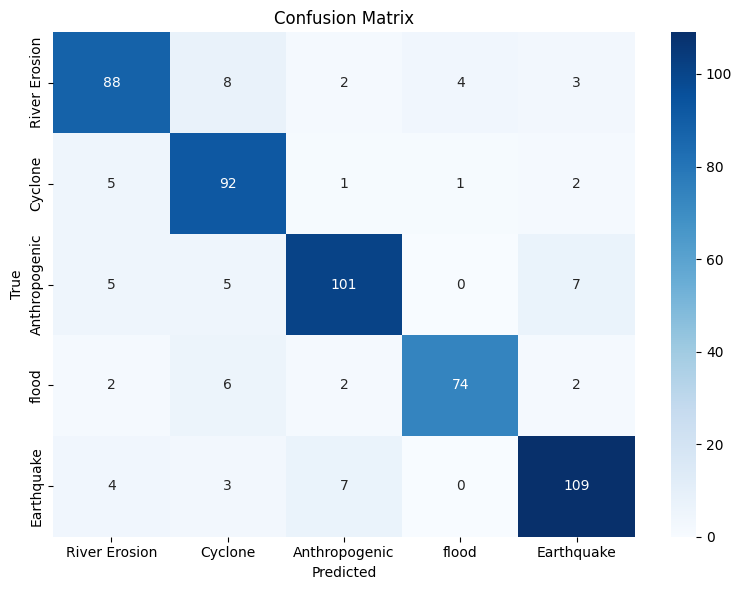

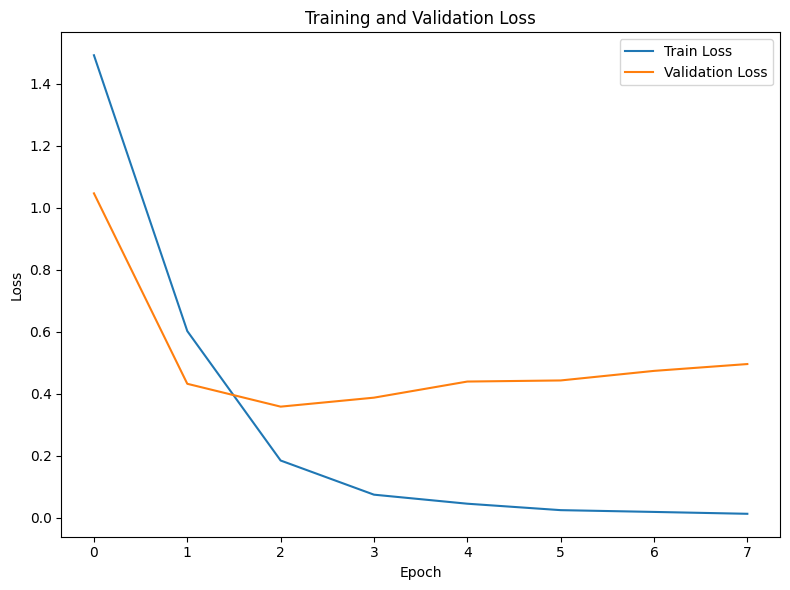

In [33]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_lstm_model.pt'))
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Metrics:\n{classification_report(test_labels, test_preds, target_names=label_mapping.keys())}')

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix_lstm.png')
plt.show()

# Loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('loss_curve_lstm.png')
plt.show()